# Финальное задание - предсказание победителя в DotA 2

## Data overview

In [1]:
import pandas as pd
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)

import numpy as np

from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import time
import datetime

In [2]:
data = pd.read_csv('data/features.csv',index_col = 'match_id')

In [3]:
data.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


#### Описание признаков в таблице

- `match_id`: идентификатор матча в наборе данных
- `start_time`: время начала матча (unixtime)
- `lobby_type`: тип комнаты, в которой собираются игроки (расшифровка в `dictionaries/lobbies.csv`)
- Наборы признаков для каждого игрока (игроки команды Radiant — префикс `rN`, Dire — `dN`):
    - `r1_hero`: герой игрока (расшифровка в dictionaries/heroes.csv)
    - `r1_level`: максимальный достигнутый уровень героя (за первые 5 игровых минут)
    - `r1_xp`: максимальный полученный опыт
    - `r1_gold`: достигнутая ценность героя
    - `r1_lh`: число убитых юнитов
    - `r1_kills`: число убитых игроков
    - `r1_deaths`: число смертей героя
    - `r1_items`: число купленных предметов
- Признаки события "первая кровь" (first blood). Если событие "первая кровь" не успело произойти за первые 5 минут, то признаки принимают пропущенное значение
    - `first_blood_time`: игровое время первой крови
    - `first_blood_team`: команда, совершившая первую кровь (0 — Radiant, 1 — Dire)
    - `first_blood_player1`: игрок, причастный к событию
    - `first_blood_player2`: второй игрок, причастный к событию
- Признаки для каждой команды (префиксы `radiant_` и `dire_`)
    - `radiant_bottle_time`: время первого приобретения командой предмета "bottle"
    - `radiant_courier_time`: время приобретения предмета "courier" 
    - `radiant_flying_courier_time`: время приобретения предмета "flying_courier" 
    - `radiant_tpscroll_count`: число предметов "tpscroll" за первые 5 минут
    - `radiant_boots_count`: число предметов "boots"
    - `radiant_ward_observer_count`: число предметов "ward_observer"
    - `radiant_ward_sentry_count`: число предметов "ward_sentry"
    - `radiant_first_ward_time`: время установки командой первого "наблюдателя", т.е. предмета, который позволяет видеть часть игрового поля
- Итог матча (данные поля отсутствуют в тестовой выборке, поскольку содержат информацию, выходящую за пределы первых 5 минут матча)
    - `duration`: длительность
    - `radiant_win`: 1, если победила команда Radiant, 0 — иначе
    - Состояние башен и барраков к концу матча (см. описание полей набора данных)
        - `tower_status_radiant`
        - `tower_status_dire`
        - `barracks_status_radiant`
        - `barracks_status_dire`

## Visual analysis

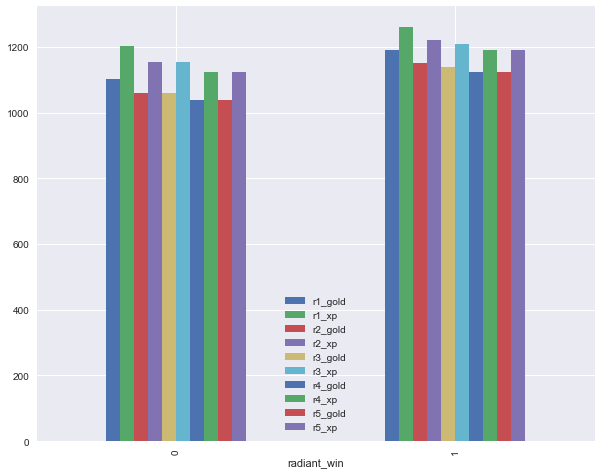

In [4]:
data.groupby('radiant_win').mean()[['r1_gold','r1_xp','r2_gold','r2_xp','r3_gold','r3_xp','r4_gold','r4_xp','r5_gold','r5_xp']].plot.bar()

* В среднем, в случае победы команды Radiant - количество золота и денег у героев выше, чем в случае ее поражения. 

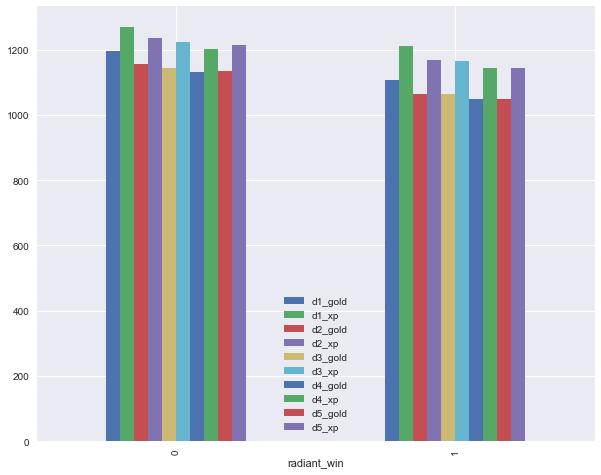

In [5]:
data.groupby('radiant_win').mean()[['d1_gold','d1_xp','d2_gold','d2_xp','d3_gold','d3_xp','d4_gold','d4_xp','d5_gold','d5_xp']].plot.bar()

* Такая же ситуация с Dire - в среднем, в случае победы команды Dire - количество золота и денег у героев выше, чем в случае ее поражения.

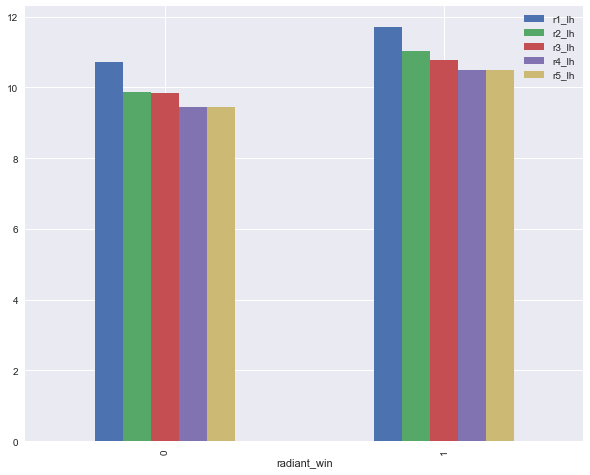

In [6]:
data.groupby('radiant_win').mean()[['r1_lh','r2_lh','r3_lh','r4_lh','r5_lh']].plot.bar()

* Так же видно, что количество добитых крипов за 5 минут у Radiant в случае победы выше. Оно и неудивительно, так как опыта и денег у них тоже выше в случае победы.

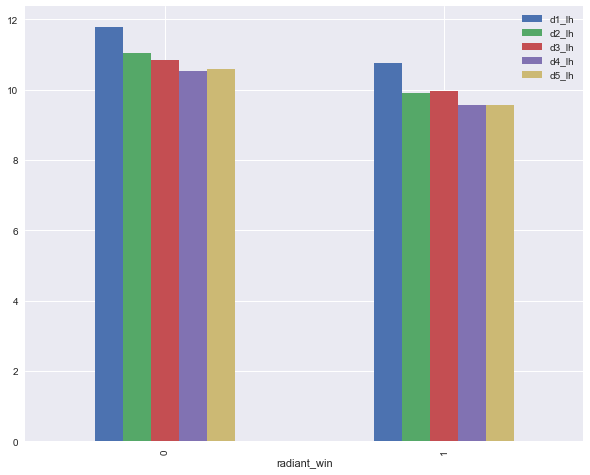

In [7]:
data.groupby('radiant_win').mean()[['d1_lh','d2_lh','d3_lh','d4_lh','d5_lh']].plot.bar()

* Аналогичная ситуация с Dire

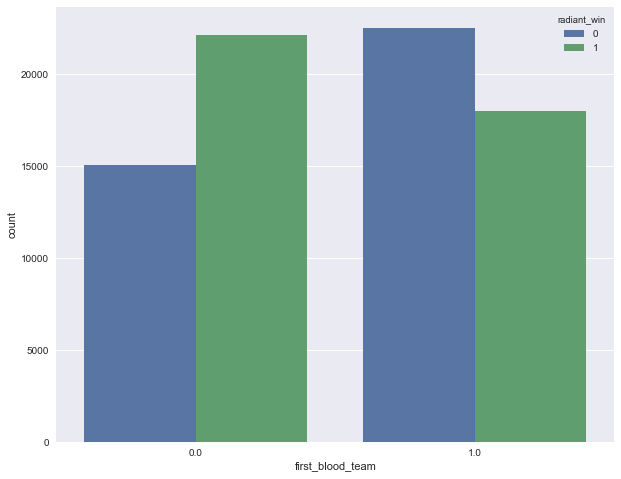

In [8]:
sns.countplot(x = 'first_blood_team', hue = 'radiant_win',data = data)

* А вот Первая Кровь очень сильно влияет на победу

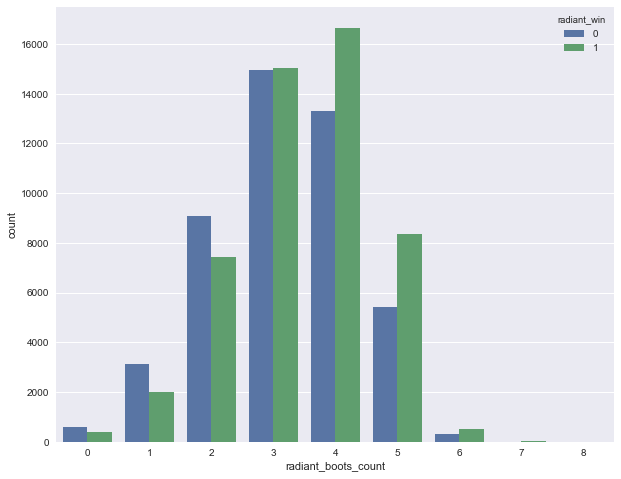

In [9]:
sns.countplot(x = 'radiant_boots_count',hue = 'radiant_win',data = data)

In [10]:
bottle = []
for i in range(0,len(data)):
    if((np.isnan(data.iloc[i]['radiant_bottle_time']) == False) & (np.isnan(data.iloc[i]['dire_bottle_time']) == False)):
        bottle.append(0)
    else:
        if(np.isnan(data.iloc[i]['radiant_bottle_time']) == False): 
            bottle.append(1)
        else:
            bottle.append(-1)
data['bottle'] = bottle

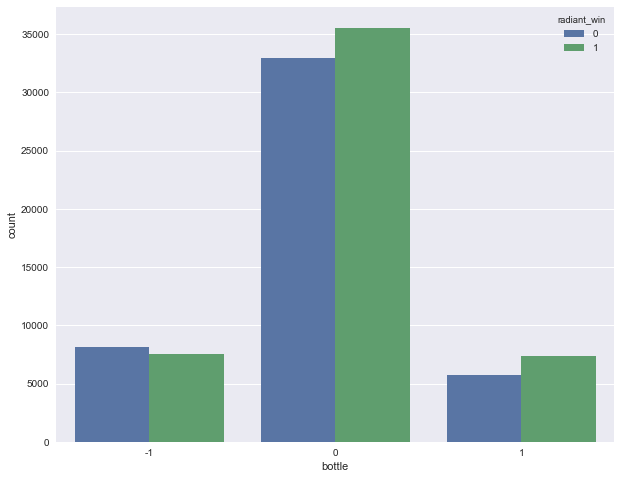

In [11]:
sns.countplot(x = 'bottle',hue = 'radiant_win',data = data)

* -1 - Bootle только в команде Dire
* 0 - Bootle в обеих командах
* 1 - Bootle только в команде Radiant

Видно, что команда с Bottle побеждает чаще

In [12]:
data['radiant_bottle_time'] = data['radiant_bottle_time']//60
data['dire_bottle_time'] = data['dire_bottle_time']//60

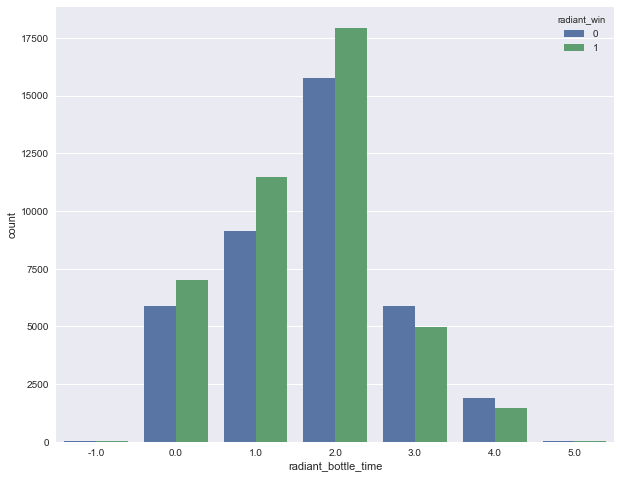

In [13]:
sns.countplot(x = 'radiant_bottle_time',hue = 'radiant_win',data = data)

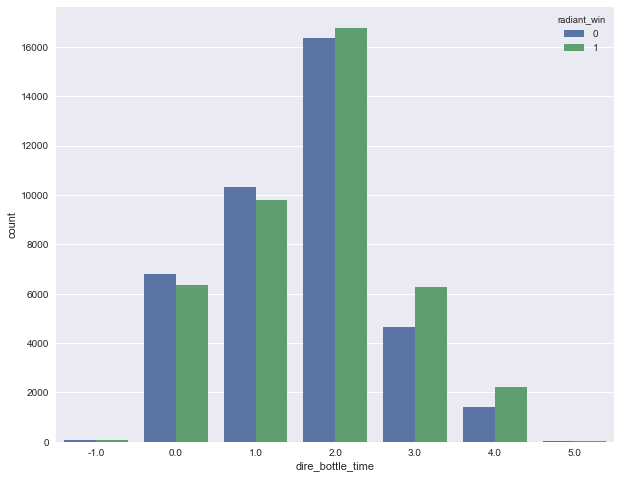

In [14]:
sns.countplot(x = 'dire_bottle_time',hue = 'radiant_win',data = data)

* Кроме того, команда, у которой Bootle куплен раньше 2 минуты, побеждает чаще.

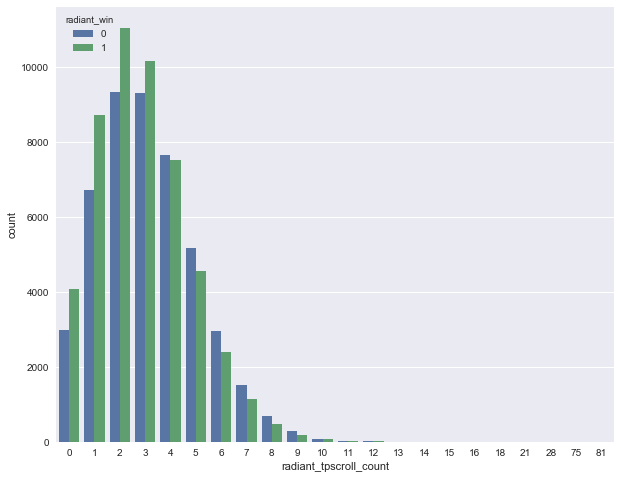

In [15]:
sns.countplot(x = 'radiant_tpscroll_count',hue = 'radiant_win',data = data)

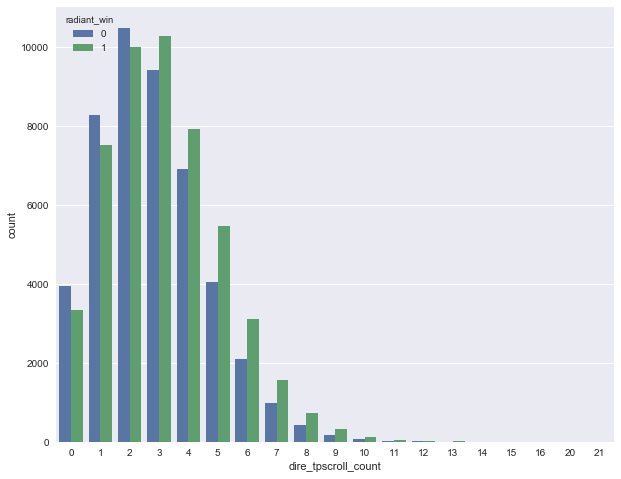

In [16]:
sns.countplot(x = 'dire_tpscroll_count',hue = 'radiant_win',data = data)

* Можно так же предположить, что чем меньше команда покупает свитков телепортации, тем чаще побеждает

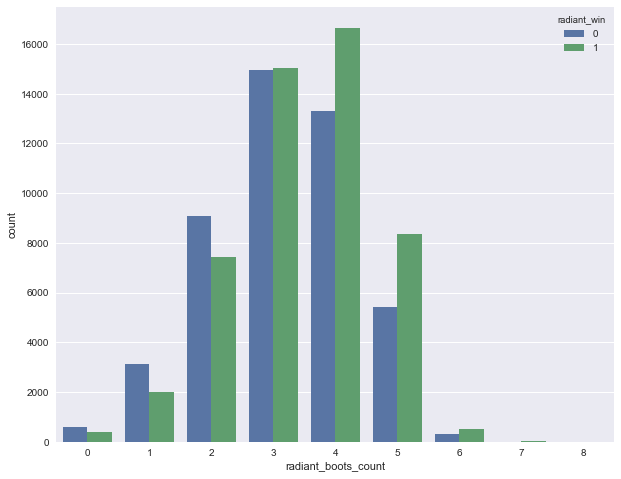

In [17]:
sns.countplot(x = 'radiant_boots_count',hue = 'radiant_win',data = data)

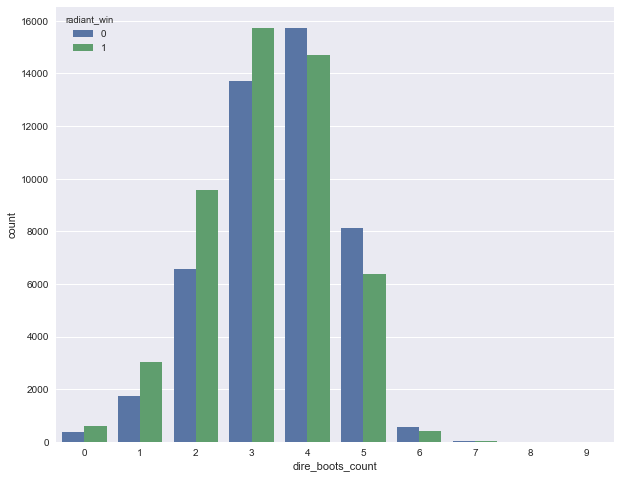

In [18]:
sns.countplot(x = 'dire_boots_count',hue = 'radiant_win',data = data)

* Так же, чем больше ботинков, тем больше побед

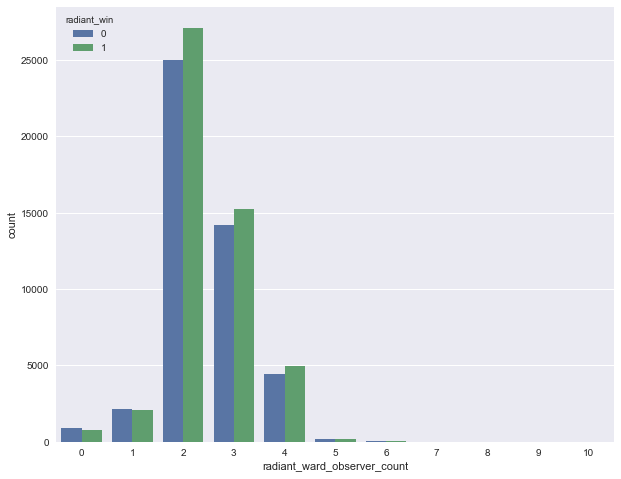

In [19]:
sns.countplot(x = 'radiant_ward_observer_count',hue = 'radiant_win',data = data)

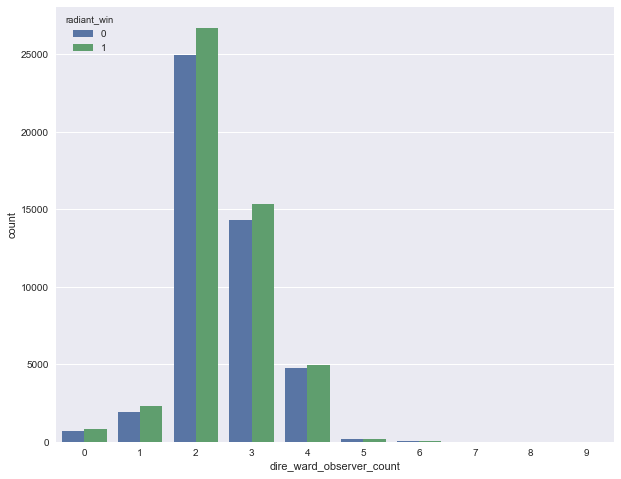

In [20]:
sns.countplot(x = 'dire_ward_observer_count',hue = 'radiant_win',data = data)

* Забавно, но скорее всего варды на стороне Radiant имеют более важное значение, чем за Dire

## NaN overview

In [21]:
data.describe().T['count'][data.describe().T['count'] < len(data)].sort_values().apply(lambda x: (len(data) - x) / len(data))

first_blood_player2            0.452402
radiant_flying_courier_time    0.282619
dire_flying_courier_time       0.268415
first_blood_time               0.201100
first_blood_team               0.201100
first_blood_player1            0.201100
dire_bottle_time               0.166029
radiant_bottle_time            0.161380
radiant_first_ward_time        0.018883
dire_first_ward_time           0.018780
radiant_courier_time           0.007117
dire_courier_time              0.006953
Name: count, dtype: float64

* **Данные за пять минут игры**
* **first_blood_player2** - Первое убийство, совершенное одним игроком (в 45% случаев)
* **radiant_flying_courier_time** - Время покупки летающего курьера за команду Radiant (в 28% случаев не покупается летающий курьер)
* **dire_flying_courier_time** - То же самое за Dire
* **first_blood_time** - Время первого убийства (в 20% случаев не совершается первого убийства)
* **first_blood_team**  - Команда, совершившая первая убийство
* **first_blood_player1** - Игрок, совершивший первое убийство
* **dire_bottle_time** - Время покупки Bootle за команду Dire (в 16% случаев не покупаетя Bottle)
* **radiant_bottle_time** - То же самое за Radiant
* **radiant_first_ward_time** - Время установки первого Варда (в 1% случаев вард не ставится)
* **dire_first_ward_time** - То же самое за Dire
* **radiant_courier_time** - Время покупки обычного курьера (в 0.5% случаев курьер не покупается)
* **dire_courier_time** - То же самое за Dire

## Clean & prepare data

Заполним пропуски нулями

In [22]:
data.fillna(0,inplace = True)

Удалим данные о будущем

In [23]:
data.drop(['duration', 
         'tower_status_radiant', 
         'tower_status_dire', 
         'barracks_status_radiant', 
         'barracks_status_dire',
         'bottle',
        ], axis=1, inplace=True)

In [24]:
X_train = data
y_train = data['radiant_win'].to_frame()
X_train.drop(['radiant_win'],axis = 1,inplace = True)

* X_train - матрица объект-признак
* y_train - целевая переменная

# Подход 1: градиентный бустинг "в лоб"

In [25]:
cv = KFold(n_splits = 5, shuffle=True)

In [26]:
scores = list()
for k in (10,20,30,50,100):
    start_time = datetime.datetime.now()

    model = GradientBoostingClassifier(n_estimators=k)
    scores.append(cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc'))
    
    print ('#' + str(k) + ' Time elapsed:      ' + str(datetime.datetime.now() - start_time))
    print ('SCORES:  ' + str(scores[-1]) + '    mean:   ' + str(np.mean(scores[-1])))
    print()

#10 Time elapsed:      0:00:37.817274
SCORES:  [ 0.65505542  0.66373262  0.66691574  0.664949    0.6645377 ]    mean:   0.663038098237

#20 Time elapsed:      0:01:05.080687
SCORES:  [ 0.67579216  0.67896546  0.685442    0.68540344  0.68659162]    mean:   0.682438936902

#30 Time elapsed:      0:01:32.228668
SCORES:  [ 0.69477413  0.68488372  0.69103648  0.68591386  0.68900904]    mean:   0.689123448998

#50 Time elapsed:      0:02:35.382554
SCORES:  [ 0.69552207  0.69168742  0.69759813  0.70065433  0.7030596 ]    mean:   0.697704313159

#100 Time elapsed:      0:05:38.063005
SCORES:  [ 0.70024004  0.70869632  0.70666936  0.70910088  0.70827143]    mean:   0.706595605069



Выше время выполнения Кросс-Валидации для разного количества деревьев с соответствующими значениями метрики AUC-ROC

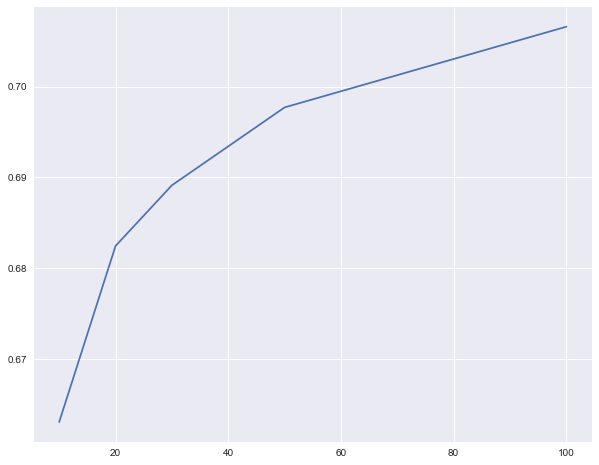

In [27]:
plt.plot((10,20,30,50,100),np.mean(scores,axis = 1))

Имеет смысл использовать больше 30 деревьев, так как с увелечением количества деревьев увеличиваются значения метрики AUC-ROC  
Если все работает очень медлено:
* Используйте для обучения и кросс-валидации не всю выборку, а некоторое ее подмножество — например, половину объектов. Подмножество лучше всего брать случайным, а не формировать его из первых m объектов.
* Попробуйте упростить модель — например, уменьшить глубину деревьев в градиентом бустинге (max_depth).

# Подход 2: логистическая регрессия¶

In [28]:
X_train = StandardScaler().fit_transform(X_train)

In [29]:
scores = list()

for c in [10 ** i for i in range(-3, 5)]:
    start_time = datetime.datetime.now()
    
    model = LogisticRegression(C = c)
    scores.append(cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc'))
    
    print ('#' + str(c) + ' Time elapsed:      ' + str(datetime.datetime.now() - start_time))
    print ('SCORES:  ' + str(scores[-1]) + '    mean:   ' + str(np.mean(scores[-1])))
    print()


#0.001 Time elapsed:      0:00:12.784729
SCORES:  [ 0.71719904  0.71339884  0.71605577  0.71087213  0.72374592]    mean:   0.716254339733

#0.01 Time elapsed:      0:00:14.950639
SCORES:  [ 0.71013673  0.72113068  0.71944063  0.71801731  0.71389886]    mean:   0.71652484431

#0.1 Time elapsed:      0:00:15.435319
SCORES:  [ 0.70865003  0.71385571  0.71943653  0.71990228  0.71915761]    mean:   0.716200432658

#1 Time elapsed:      0:00:14.934511
SCORES:  [ 0.71518066  0.71675327  0.71483414  0.7187316   0.71586339]    mean:   0.716272612495

#10 Time elapsed:      0:00:17.077573
SCORES:  [ 0.72288082  0.71602472  0.71560763  0.7089844   0.718947  ]    mean:   0.71648891357

#100 Time elapsed:      0:00:16.240816
SCORES:  [ 0.71628396  0.71427024  0.71757346  0.7153179   0.71931484]    mean:   0.716552081161

#1000 Time elapsed:      0:00:14.921184
SCORES:  [ 0.71215672  0.71538696  0.71459244  0.71833076  0.7202693 ]    mean:   0.71614723508

#10000 Time elapsed:      0:00:14.058134
SC

Выше время выполнения Кросс-Валидации для разного параметра регуляризации С с соответствующими значениями метрики AUC-ROC

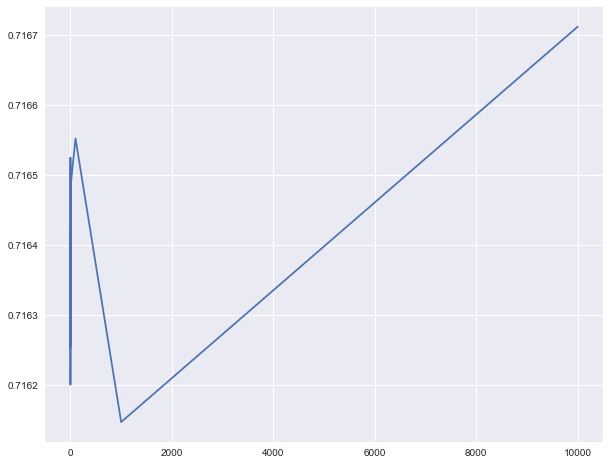

In [30]:
plt.plot([10 ** i for i in range(-3, 5)],np.mean(scores,axis = 1))

Лучшее значение метрики AUC-ROC = 0.716711764404 при C = 10000. Это выше чем при бустинге со 100 деревьявми.

### Delete categorical features

In [31]:
data.drop([
    'lobby_type',
    'r1_hero',
    'r2_hero',
    'r3_hero',
    'r4_hero',
    'r5_hero',
    'd1_hero',
    'd2_hero',
    'd3_hero',
    'd4_hero',
    'd5_hero',
],axis = 1, inplace = True)

In [32]:
X_train = data

In [33]:
X_train = StandardScaler().fit_transform(X_train)

In [34]:
scores = list()

for c in [10 ** i for i in range(-3, 5)]:
    start_time = datetime.datetime.now()
    
    model = LogisticRegression(C = c)
    scores.append(cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc'))
    
    print ('#' + str(c) + ' Time elapsed:      ' + str(datetime.datetime.now() - start_time))
    print ('SCORES:  ' + str(scores[-1]) + '    mean:   ' + str(np.mean(scores[-1])))
    print()

#0.001 Time elapsed:      0:00:09.511150
SCORES:  [ 0.71513947  0.71844533  0.7128657   0.71988929  0.71471009]    mean:   0.716209975367

#0.01 Time elapsed:      0:00:12.660536
SCORES:  [ 0.71864793  0.71457556  0.72200515  0.71568565  0.71176097]    mean:   0.716535054382

#0.1 Time elapsed:      0:00:13.331936
SCORES:  [ 0.72054981  0.71729063  0.71775769  0.70907106  0.71878811]    mean:   0.716691459827

#1 Time elapsed:      0:00:13.055729
SCORES:  [ 0.71179401  0.71262913  0.71419483  0.72272713  0.72058183]    mean:   0.716385385352

#10 Time elapsed:      0:00:13.000544
SCORES:  [ 0.71719573  0.71525239  0.71498437  0.71794542  0.71651876]    mean:   0.716379334385

#100 Time elapsed:      0:00:13.644508
SCORES:  [ 0.71186227  0.7169295   0.71867739  0.7178382   0.71582669]    mean:   0.716226810982

#1000 Time elapsed:      0:00:12.941582
SCORES:  [ 0.71578631  0.72065651  0.7121417   0.71767142  0.71455662]    mean:   0.716162510378

#10000 Time elapsed:      0:00:12.921348

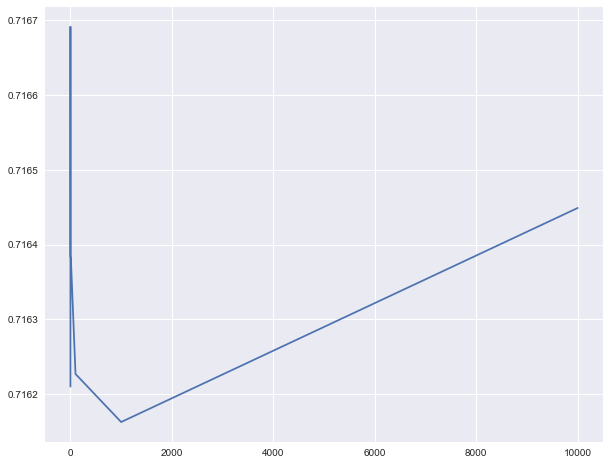

In [37]:
plt.plot([10 ** i for i in range(-3, 5)],np.mean(scores,axis = 1))

Лучшее значение метрики AUC-ROC при C = 0.1 и это хуже, чем было без удаления категориальных признаков, однако значение регуляризации тоже поменялось. Скорее всего, нужно было поставить значение random_state. 

In [115]:
data = pd.read_csv('data/features.csv',index_col='match_id')
data.drop(['duration', 
         'tower_status_radiant', 
         'tower_status_dire', 
         'barracks_status_radiant', 
         'barracks_status_dire',
         'radiant_win'
        ], axis=1, inplace=True)

data.fillna(0,inplace = True)

In [44]:
unique = set()
for i in range(1,6):
    unique = unique.union(set(data['r' + str(i) + '_hero'].unique() + data['d' + str(i) + '_hero'].unique()))

In [51]:
print(str(len(unique)) + ' уникальных героя')

173 уникальных героя


### Bag of words

* В кажой игре 10 разных героев. Всего уникальных - 108. 

In [116]:
X_pick = np.zeros((data.shape[0], 112))

for i, match_id in enumerate(data.index):
    for p in range(5):
        X_pick[i, data.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, data.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1
        
data.drop([
    'lobby_type',
    'r1_hero',
    'r2_hero',
    'r3_hero',
    'r4_hero',
    'r5_hero',
    'd1_hero',
    'd2_hero',
    'd3_hero',
    'd4_hero',
    'd5_hero',
],axis = 1, inplace = True)

In [64]:
X_train = np.hstack((data.values, X_pick))

In [65]:
X_train = StandardScaler().fit_transform(X_train)

In [66]:
scores = list()

for c in [10 ** i for i in range(-3, 5)]:
    start_time = datetime.datetime.now()
    
    model = LogisticRegression(C = c)
    scores.append(cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc'))
    
    print ('#' + str(c) + ' Time elapsed:      ' + str(datetime.datetime.now() - start_time))
    print ('SCORES:  ' + str(scores[-1]) + '    mean:   ' + str(np.mean(scores[-1])))
    print()

#0.001 Time elapsed:      0:00:23.287210
SCORES:  [ 0.75506653  0.75263408  0.75076167  0.74638333  0.75307821]    mean:   0.751584764943

#0.01 Time elapsed:      0:00:29.100590
SCORES:  [ 0.75086734  0.75528828  0.74805472  0.75343997  0.75288278]    mean:   0.75210661888

#0.1 Time elapsed:      0:00:29.958878
SCORES:  [ 0.75424882  0.7534608   0.74989107  0.747009    0.75510353]    mean:   0.751942641557

#1 Time elapsed:      0:00:28.849180
SCORES:  [ 0.75739825  0.75745169  0.7411224   0.75574706  0.7474153 ]    mean:   0.751826940273

#10 Time elapsed:      0:00:31.370563
SCORES:  [ 0.74836005  0.75499955  0.74903942  0.75362     0.75382919]    mean:   0.751969642312

#100 Time elapsed:      0:00:27.754022
SCORES:  [ 0.74982122  0.75309886  0.7551166   0.75371573  0.7479433 ]    mean:   0.751939142732

#1000 Time elapsed:      0:00:28.865714
SCORES:  [ 0.75085849  0.75377298  0.75407422  0.75353857  0.74655167]    mean:   0.751759188592

#10000 Time elapsed:      0:00:26.657184


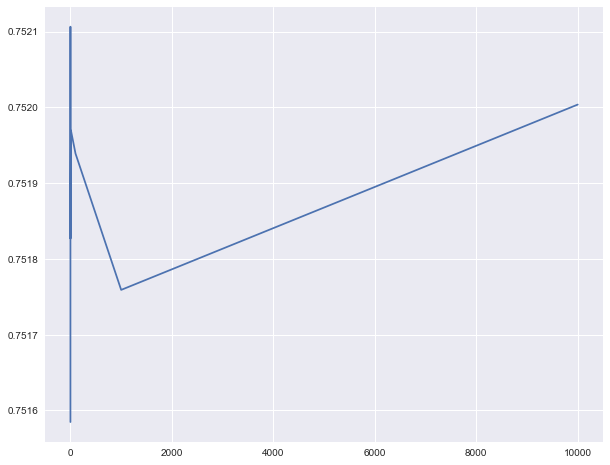

In [67]:
plt.plot([10 ** i for i in range(-3, 5)],np.mean(scores,axis = 1))

При добавления "мешка слов" по героям качество заметно улучшается. Лучшее значение метрики AUC-ROC = 0.751942641557, при C = 0.1. Объясняется тем, что добавили новые фичи из категориальных признаков.

### Submit

In [102]:
data = pd.read_csv('data/features.csv',index_col='match_id')
data.drop(['duration', 
         'tower_status_radiant', 
         'tower_status_dire', 
         'barracks_status_radiant', 
         'barracks_status_dire',
         'radiant_win'
        ], axis=1, inplace=True)

data.fillna(0,inplace = True)

X_pick = np.zeros((data.shape[0], 112))

for i, match_id in enumerate(data.index):
    for p in range(5):
        X_pick[i, data.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, data.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1
        
data.drop([
    'lobby_type',
    'r1_hero',
    'r2_hero',
    'r3_hero',
    'r4_hero',
    'r5_hero',
    'd1_hero',
    'd2_hero',
    'd3_hero',
    'd4_hero',
    'd5_hero',
],axis = 1, inplace = True)


X_train = np.hstack((data.values, X_pick))
X_train = StandardScaler().fit_transform(X_train)
###


data = pd.read_csv('data/features_test.csv',index_col='match_id')
data.fillna(0,inplace = True)


X_pick = np.zeros((data.shape[0], 112))

for i, match_id in enumerate(data.index):
    for p in range(5):
        X_pick[i, data.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, data.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1
        
data.drop([
    'lobby_type',
    'r1_hero',
    'r2_hero',
    'r3_hero',
    'r4_hero',
    'r5_hero',
    'd1_hero',
    'd2_hero',
    'd3_hero',
    'd4_hero',
    'd5_hero',
],axis = 1, inplace = True)

X_test = np.hstack((data.values, X_pick))
X_test = StandardScaler().fit_transform(X_test)

In [72]:
model = LogisticRegression(C=0.01)
model.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [74]:
submit = model.predict_proba(X_test)

In [84]:
submit = [submit[i][1] for i in range(0,len(submit))]

In [109]:
print('Max proba: ' + str(max(submit)))
print('Min proba: ' + str(min(submit)))

Max proba: 0.996403192335
Min proba: 0.0085950410782


In [103]:
pd.DataFrame(data = submit, index = data.index, columns=['radiant_win']).to_csv('kaggle_submit.csv')

- Результат с kaggle - **0.75531**